# Importação das bibliotecas

In [1]:
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Estatísticas
import scipy.stats as stats

# Análise de Séries Temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Seleção Automática de Modelos SARIMA
from pmdarima import auto_arima

# Algoritmo de Aprendizado de Máquina
import xgboost as xgb

## Funções Auxiliares

In [2]:
#@markdown dfdisplay
class dfdisplay(object):
    # Adaptado de https://jakevdp.github.io/PythonDataScienceHandbook/index.html
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <hr>
    <h3 style='font-family:"Courier New", Courier, monospace'>{0}</h3><hr>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        # print(self.args, self.args[0], self.args[1], self.args[2], str(self.args[1]))

    def _repr_html_(self):
        return '\n'.join(self.template.format(str(self.args[0]), eval(a + '.head(' + str(self.args[1]) + ')')._repr_html_())
                         for a in [self.args[2]])

    def __repr__(self):
        return '\n\n'.join(str(self.args[0])+ '\n' + repr(eval(a + '.head(' + str(self.args[1]) + ')'))
                           for a in [self.args[2]])


In [3]:
#@markdown gera_df_stats_latex
from IPython.display import display, Latex, HTML
import warnings

def gera_df_stats_latex(df_stats, titulo):

  warnings.filterwarnings('ignore')
  # latex_table = df_stats.style.to_latex(hrules=True)
  latex_table = df_stats.to_latex(index=None)
  # display(Latex(latex_table))

  latex_table = latex_table.replace('tabular','array')
  latex_table = latex_table.replace('toprule','hline')
  latex_table = latex_table.replace('midrule','hline')
  latex_table = latex_table.replace('bottomrule','hline')

  latex_table = '\\textbf{' + titulo + '} \\\\' + latex_table

  warnings.filterwarnings('default')
  return latex_table

## Métricas de Erro

In [4]:
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error
)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def error_metrics(y_true, y_pred):

    def error_sub_metrics(medida, y_true, y_pred):
        m = []
        for i in range(len(y_pred)):
            m.append(medida([y_true[i]], [y_pred[i]]))
        m = np.array(m)

        return m.std().round(2), m.min().round(2), m.max().round(2)

    metrics = {}

    # Métricas principais
    metrics['R2'] = np.round(r2_score(y_true, y_pred), 2)
    metrics['RMSE'] = root_mean_squared_error(y_true, y_pred).round(2)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred).round(2)
    metrics['MedAE'] = median_absolute_error(y_true, y_pred).round(2)
    metrics['MAPE'] = mean_absolute_percentage_error(y_true, y_pred).round(2)

    # Estatísticas adicionais para cada métrica
    metrics['RMSE_std'], metrics['RMSE_min'], metrics['RMSE_max'] = error_sub_metrics(root_mean_squared_error, y_true, y_pred)
    metrics['MAE_std'], metrics['MAE_min'], metrics['MAE_max'] = error_sub_metrics(mean_absolute_error, y_true, y_pred)
    metrics['MedAE_std'], metrics['MedAE_min'], metrics['MedAE_max'] = error_sub_metrics(median_absolute_error, y_true, y_pred)
    metrics['MAPE_std'], metrics['MAPE_min'], metrics['MAPE_max'] = error_sub_metrics(mean_absolute_percentage_error, y_true, y_pred)

    return metrics

## Resultados Gráficos

In [5]:
def plot_results1():
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].plot(y_true, label='Real')
    ax[0].plot(y_pred, 'r', label='Previsto')
    ax[0].set_title(f'{modelo}\n{AICRMSE_str} = {AICRMSE_value:.2f}', weight='bold', fontsize=10)
    ax[0].set_xlabel('Período')
    ax[0].set_ylabel('Receita')
    ax[0].tick_params(axis='x', labelsize=6)
    ax[0].tick_params(axis='y', labelsize=8)
    ax[0].legend(fontsize=8)

    ax[1].bar(range(len(errors)), errors)
    min_error_index = np.argmin(np.abs(errors))
    ax[1].bar(min_error_index, errors[min_error_index], color='green')
    max_error_index = np.argmax(np.abs(errors))
    ax[1].bar(max_error_index, errors[max_error_index], color='red')
    ax[1].set_title(f'{modelo}\nMedAE = {metrics_df["MedAE"].values[0]:.2f}', weight='bold', fontsize=10)
    ax[1].set_xlabel('Período')
    ax[1].tick_params(axis='x', labelsize=6)
    ax[1].tick_params(axis='y', labelsize=8)

    stats.probplot(errors, dist="norm", plot=ax[2])
    ax[2].set_title(f'{modelo}\nQQ Plot dos Resíduos', weight='bold', fontsize=10)
    ax[2].tick_params(axis='x', labelsize=6)
    ax[2].tick_params(axis='y', labelsize=8)

    plt.suptitle(suptitle, weight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()

    return

## Previsões Janela Deslizante

In [6]:
def forecast_rolling(model, init_data, n_lags, steps):
    predictions = []
    history = list(init_data[-n_lags:])
    # print(history)
    for _ in range(steps):

        X_next = [history[-n_lags:]]
        # print(X_next)

        # Previsão do próximo valor
        next_pred = model.predict(X_next)[0]

        # Adiciona a previsão à lista de previsões
        predictions.append(next_pred)

        # Atualiza o histórico com a previsão atual
        history.append(next_pred)

    return predictions

# Pré-processamento dos dados

In [7]:
df = pd.read_excel("receitas_consolidadas_2021_2024.xlsx")
df.head()

,categoria,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,acessório,5073.5,6584.49,1214.0,2581.99,6648.93,5391.47,7852.47,9498.00,8967.5,...,8690.5,9165.50,7449.99,13999.50,12320.50,21194.5,7934.00,9888.00,14670.0,14239.00
1,beleza_e_estética,1272.5,1405.00,337.5,706.00,1763.50,1700.50,1912.00,1790.50,1854.0,...,1952.0,2443.50,2176.00,3383.50,2255.50,1950.5,1214.00,1450.00,1892.5,1811.00
2,brinquedo,5203.0,4858.00,1563.5,2172.50,6014.50,5068.50,6734.10,5903.50,7812.0,...,5667.4,12910.10,5197.90,12748.60,6292.30,7441.9,5041.00,7349.20,6774.1,7377.20
3,calçado,1684.0,1426.00,416.0,753.00,2943.00,3008.00,2580.00,2085.00,1415.0,...,1931.0,1857.00,1559.00,1678.00,1757.00,2133.0,1463.00,2287.00,2701.0,2101.00
4,doce,487.0,566.50,35.0,133.25,477.00,360.00,601.25,734.25,596.0,...,1422.0,1640.25,1476.00,1866.25,1545.75,2227.0,1095.25,1532.25,1666.5,1844.75


In [8]:
df['categoria'].unique()

array(['acessório', 'beleza_e_estética', 'brinquedo', 'calçado', 'doce',
       'eletrônico', 'enfeite', 'escritório', 'material_escolar', 'natal',
       'pet', 'presente', 'utilidade', 'vestuário', 'Total'], dtype=object)

In [9]:
import unicodedata

def normalize_categoria(text):
  text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
  text = text.replace('_', '-')
  text = text.lower()
  return text

df['categoria'] = df['categoria'].apply(normalize_categoria)
df['categoria'].unique()

array(['acessorio', 'beleza-e-estetica', 'brinquedo', 'calcado', 'doce',
       'eletronico', 'enfeite', 'escritorio', 'material-escolar', 'natal',
       'pet', 'presente', 'utilidade', 'vestuario', 'total'], dtype=object)

In [10]:
df.to_csv('receitas_consolidadas_2021_2024.csv', index=False)

In [11]:
df = pd.read_csv("receitas_consolidadas_2021_2024.csv",index_col='categoria')
df.head()

,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
categoria,,,,,,,,,,,,,,,,,,,,,
acessorio,5073.5,6584.49,1214.0,2581.99,6648.93,5391.47,7852.47,9498.00,8967.5,9101.49,...,8690.5,9165.50,7449.99,13999.50,12320.50,21194.5,7934.00,9888.00,14670.0,14239.00
beleza-e-estetica,1272.5,1405.00,337.5,706.00,1763.50,1700.50,1912.00,1790.50,1854.0,2465.50,...,1952.0,2443.50,2176.00,3383.50,2255.50,1950.5,1214.00,1450.00,1892.5,1811.00
brinquedo,5203.0,4858.00,1563.5,2172.50,6014.50,5068.50,6734.10,5903.50,7812.0,16620.00,...,5667.4,12910.10,5197.90,12748.60,6292.30,7441.9,5041.00,7349.20,6774.1,7377.20
calcado,1684.0,1426.00,416.0,753.00,2943.00,3008.00,2580.00,2085.00,1415.0,1426.00,...,1931.0,1857.00,1559.00,1678.00,1757.00,2133.0,1463.00,2287.00,2701.0,2101.00
doce,487.0,566.50,35.0,133.25,477.00,360.00,601.25,734.25,596.0,659.75,...,1422.0,1640.25,1476.00,1866.25,1545.75,2227.0,1095.25,1532.25,1666.5,1844.75


In [12]:
ts = pd.DataFrame()

for categoria in df.index:
  ts = pd.concat([ts,df.loc[categoria, :]],axis=1)

ts.index = pd.date_range(start='1/1/2021', periods=len(ts), freq='MS')
ts.head()

,acessorio,beleza-e-estetica,brinquedo,calcado,doce,eletronico,enfeite,escritorio,material-escolar,natal,pet,presente,utilidade,vestuario,total
2021-01-01,5073.50,1272.5,5203.0,1684.0,487.00,4007.75,3100.25,1167.20,1771.9,150.0,407.0,1018.5,3463.60,323.0,29129.20
2021-02-01,6584.49,1405.0,4858.0,1426.0,566.50,3429.00,3154.50,2313.65,9805.6,142.8,105.0,1266.3,5229.40,656.5,40942.74
2021-03-01,1214.00,337.5,1563.5,416.0,35.00,727.50,715.00,560.35,1424.9,0.0,0.0,206.1,1288.40,242.5,8730.75
2021-04-01,2581.99,706.0,2172.5,753.0,133.25,1319.50,1488.00,561.20,2165.8,95.0,25.0,373.2,2216.25,1776.0,16366.69
2021-05-01,6648.93,1763.5,6014.5,2943.0,477.00,4120.50,6052.50,1726.85,4696.5,272.6,250.0,2309.4,5901.30,7644.5,50821.08


# Dados

,values
2021-01-01,29129.20
2021-02-01,40942.74
2021-03-01,8730.75
2021-04-01,16366.69
2021-05-01,50821.08
2021-06-01,49084.82
2021-07-01,73795.12
2021-08-01,62422.10


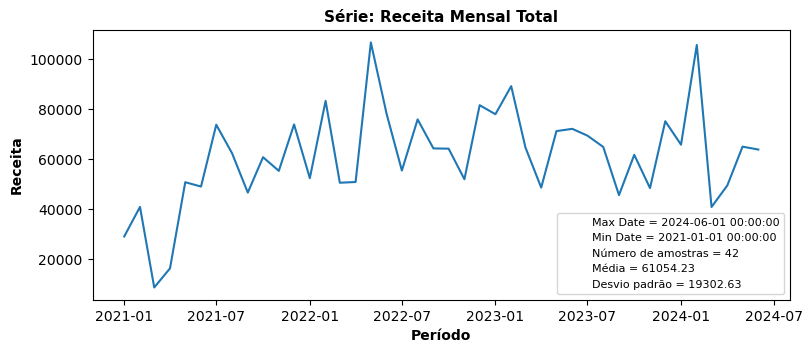

In [13]:
df = ts[['total']]
df.columns = ['values']
nome_serie = 'Receita Mensal Total'

plt.figure(figsize=(9, 3.5))
plt.plot(df)
plt.title('Série: ' + nome_serie, weight='bold', fontsize=11)
plt.xlabel('Período', weight='bold')
plt.ylabel('Receita', weight='bold')
plt.plot([], label=f'Max Date = {df.index.max()}', color='white')
plt.plot([], label=f'Min Date = {df.index.min()}', color='white')
plt.plot([], label=f'Número de amostras = {len(df)}', color='white')
plt.plot([], label=f'Média = {df.values.mean():.2f}', color='white')
plt.plot([], label=f'Desvio padrão = {df.values.std():.2f}', color='white')
plt.legend(loc='lower right', fontsize=8)

dfdisplay(nome_serie, 8, 'df')

## Estacionariedade

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
    print("A série temporal é estacionária.")
else:
    print("A série temporal não é estacionária.")

ADF Statistic: -4.900188
p-value: 0.000035
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606
A série temporal é estacionária.


## Autocorrelação dos valores

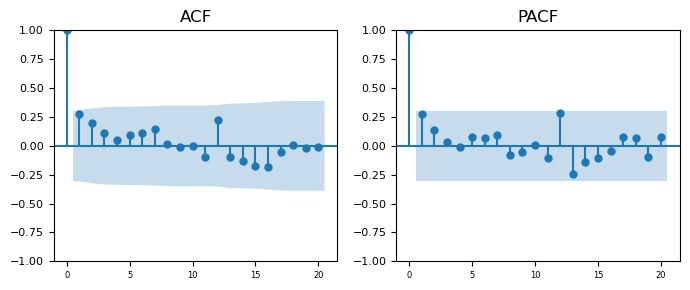

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,2,figsize=(7,3))

plot_acf(df, lags=20, ax=ax[0])
ax[0].set_title('ACF')
ax[0].tick_params(axis='x',labelsize=6)
ax[0].tick_params(axis='y',labelsize=8)

plot_pacf(df, lags=20,ax=ax[1])
ax[1].set_title('PACF')
ax[1].tick_params(axis='x',labelsize=6)
ax[1].tick_params(axis='y',labelsize=8)

plt.tight_layout()
plt.show()

# `pmdarima`: AutoARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=952.103, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=950.921, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=950.937, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1050.832, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=950.789, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=948.185, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=950.123, Time=0.11 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=949.249, Time=0.13 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=950.608, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=951.252, Time=0.02 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=949.355, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=950.572, Time=0.05 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=951.280, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12]            

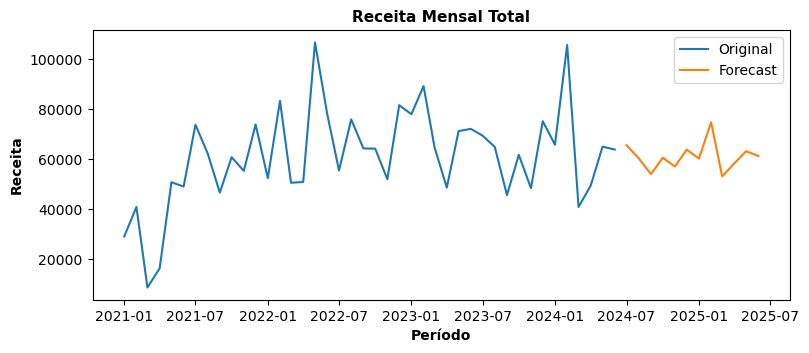

In [16]:
model = auto_arima(df, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

print(model.summary())

forecast = model.predict(n_periods=12)

plt.figure(figsize=(9,3.5))
plt.plot(df, label='Original')
plt.plot(pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS'), forecast, label='Forecast')
plt.title('Receita Mensal Total',weight='bold',fontsize=11)
plt.xlabel('Período',weight='bold')
plt.ylabel('Receita',weight='bold')
plt.legend()
plt.show()

In [17]:
model.order, model.seasonal_order, model.aic(), model.fittedvalues()[0:10].values

((1, 0, 0),
 (0, 0, 1, 12),
 948.1847926011965,
 array([60614.87867694, 52613.51735309, 55615.64789349, 47429.68251122,
        49370.05637404, 58125.35624694, 57682.20480458, 63954.19745627,
        61034.25982214, 56913.69568388]))

## Resultados: Autoarima

,,AIC,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE
order,seasonal order,,,,,,,,
"(1, 0, 0)","(0, 0, 1, 12)",948.18,17648.96,12189.8,0.35,0.85,5.37,0.0,9286.63


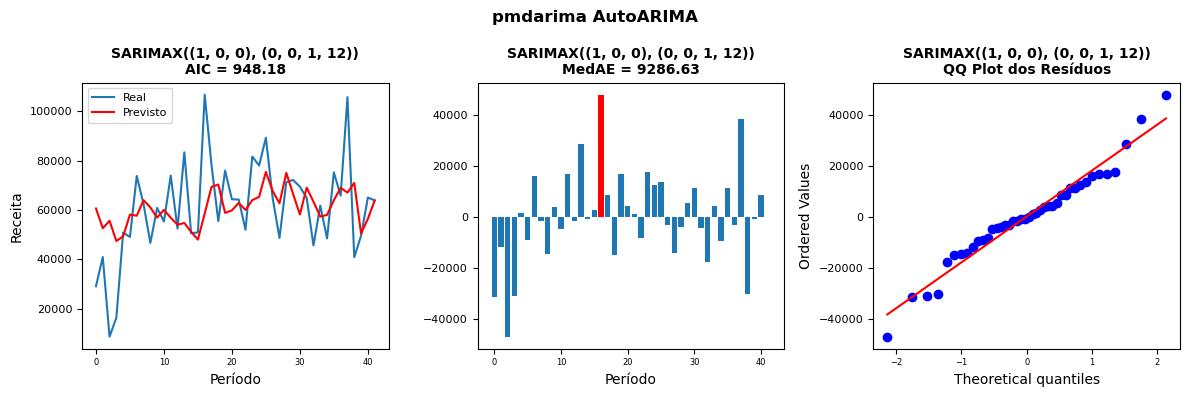

In [18]:
metrics = {}

metrics_df = pd.DataFrame.from_dict(error_metrics(df.iloc[:,0].values,  model.fittedvalues().values), orient='index').transpose()
metrics_df['order'] = str(model.order)
metrics_df['seasonal order'] = str(model.seasonal_order)
metrics_df['AIC'] = model.aic().round(2)
metrics_df['AIC'] = metrics_df['AIC'].astype(float)
metrics_df = metrics_df.set_index(['order','seasonal order'])

select_metrics = ['AIC', 'RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
model_error = metrics_df[select_metrics]

display(model_error)
print('\n\n')

y_true = df.iloc[:,0].values
y_pred = model.fittedvalues().values
AICRMSE_str = 'AIC'
AICRMSE_value = model.aic().round(2)
best_aic_model = model.order, model.seasonal_order
modelo = 'SARIMAX' + str(best_aic_model)
errors = y_true - y_pred
suptitle = 'pmdarima AutoARIMA'

plot_results1()

In [19]:
# Exemplo de uso:
temp = model_error[['AIC']].reset_index()
temp.columns = ['order', 'seasonal-order', 'AIC']
latex_table = gera_df_stats_latex(temp, 'pmdarima - melhor modelo')

# Exibe a tabela formatada em LaTeX
display(Latex(latex_table))

<IPython.core.display.Latex object>

# `statsmodels`, SARIMAX  

In [20]:
p_max = 2; d_max = 1; q_max = 2
orders = [(p, d, q) for p in range(p_max+1) for d in range(d_max+1) for q in range(q_max+1)]

P_max = 1; D_ = 0; Q_ = 0; S_ = 12
seasonal_orders = [(P, D, Q, S) for P in range(P_max+1) for D in [D_] for Q in [Q_] for S in [S_]]

orders, seasonal_orders

([(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (2, 0, 0),
  (2, 0, 1),
  (2, 0, 2),
  (2, 1, 0),
  (2, 1, 1),
  (2, 1, 2)],
 [(0, 0, 0, 12), (1, 0, 0, 12)])

In [21]:
models_stats = {}
models_fittedvalues = {}

for order in orders:
  for seasonal_order in seasonal_orders:
    model = ARIMA(df, order=order, seasonal_order=seasonal_order)
    results = model.fit(method_kwargs={'maxiter':1000})

    models_stats[(model.order, model.seasonal_order)] = {'AIC':results.aic, 'mse':results.mse, 'mae':results.mae}
    models_fittedvalues[(model.order, model.seasonal_order)] = {'fittedvalues':results.fittedvalues}

C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jhonatan Zhang Deng\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

## Sarima Seleção / Resultados

In [22]:
pd.DataFrame.from_dict(models_stats, orient='index').reset_index().sort_values('AIC',ascending=True)

,level_0,level_1,AIC,mse,mae
9,"(0, 1, 1)","(1, 0, 0, 12)",923.199794,3.145079e+08,13908.648132
11,"(0, 1, 2)","(1, 0, 0, 12)",923.972021,3.148284e+08,13834.872200
35,"(2, 1, 2)","(1, 0, 0, 12)",924.766014,2.906840e+08,13439.829379
21,"(1, 1, 1)","(1, 0, 0, 12)",925.210764,3.145487e+08,13887.764484
23,"(1, 1, 2)","(1, 0, 0, 12)",925.816999,3.132635e+08,13782.730108
33,"(2, 1, 1)","(1, 0, 0, 12)",926.419607,3.066013e+08,13684.017917
31,"(2, 1, 0)","(1, 0, 0, 12)",926.893837,3.204286e+08,14116.140623
8,"(0, 1, 1)","(0, 0, 0, 12)",927.876153,3.703562e+08,15202.804377
34,"(2, 1, 2)","(0, 0, 0, 12)",929.255803,3.357299e+08,14622.838633
20,"(1, 1, 1)","(0, 0, 0, 12)",929.871362,3.703334e+08,15224.120110


In [23]:
temp = pd.DataFrame.from_dict(models_stats, orient='index')[['AIC']].reset_index().sort_values('AIC',ascending=True)
temp.columns = ['order', 'seasonal-order', 'AIC']
latex_table = gera_df_stats_latex(temp.head(),'AIC Models')
display(Latex(latex_table))

<IPython.core.display.Latex object>

In [24]:
# reparar o erro calculado somente a partir do 1o elemento da série

min_aic_model = min(models_stats, key=lambda x: models_stats[x]['AIC'])
print(f"The model with the lowest AIC is: {min_aic_model} with AIC = {models_stats[min_aic_model]['AIC'].round(2)} and mae = {models_stats[min_aic_model]['mae'].round(2)}")
print(error_metrics(df.iloc[1::,0].values, models_fittedvalues[min_aic_model]['fittedvalues'][1::].values))

min_aic_model = min(models_stats, key=lambda x: models_stats[x]['mae'])
print(f"The model with the lowest mae is: {min_aic_model} with AIC = {models_stats[min_aic_model]['AIC'].round(2)} and mae = {models_stats[min_aic_model]['mae'].round(2)}")
print(error_metrics(df.iloc[1::,0].values, models_fittedvalues[min_aic_model]['fittedvalues'][1::].values))


The model with the lowest AIC is: ((0, 1, 1), (1, 0, 0, 12)) with AIC = 923.2 and mae = 13908.65
{'R2': 0.15, 'RMSE': 17363.28, 'MAE': 13537.42, 'MedAE': 9798.52, 'MAPE': 0.27, 'RMSE_std': 10872.99, 'RMSE_min': 100.06, 'RMSE_max': 37252.99, 'MAE_std': 10872.99, 'MAE_min': 100.06, 'MAE_max': 37252.99, 'MedAE_std': 10872.99, 'MedAE_min': 100.06, 'MedAE_max': 37252.99, 'MAPE_std': 0.34, 'MAPE_min': 0.0, 'MAPE_max': 2.02}
The model with the lowest mae is: ((2, 0, 2), (1, 0, 0, 12)) with AIC = 948.39 and mae = 12233.09
{'R2': 0.27, 'RMSE': 16174.09, 'MAE': 11752.8, 'MedAE': 8128.46, 'MAPE': 0.29, 'RMSE_std': 11111.83, 'RMSE_min': 68.91, 'RMSE_max': 39050.44, 'MAE_std': 11111.83, 'MAE_min': 68.91, 'MAE_max': 39050.44, 'MedAE_std': 11111.83, 'MedAE_min': 68.91, 'MedAE_max': 39050.44, 'MAPE_std': 0.65, 'MAPE_min': 0.0, 'MAPE_max': 4.17}


In [25]:
best_aic_model = min(models_stats, key=lambda x: models_stats[x]['AIC'])
print(f"The model with the lowest AIC is: {best_aic_model} with AIC = {models_stats[best_aic_model]['AIC'].round(2)} and mae = {models_stats[best_aic_model]['mae'].round(2)}")
print(error_metrics(df.iloc[1::,0].values, models_fittedvalues[best_aic_model]['fittedvalues'][1::].values))

The model with the lowest AIC is: ((0, 1, 1), (1, 0, 0, 12)) with AIC = 923.2 and mae = 13908.65
{'R2': 0.15, 'RMSE': 17363.28, 'MAE': 13537.42, 'MedAE': 9798.52, 'MAPE': 0.27, 'RMSE_std': 10872.99, 'RMSE_min': 100.06, 'RMSE_max': 37252.99, 'MAE_std': 10872.99, 'MAE_min': 100.06, 'MAE_max': 37252.99, 'MedAE_std': 10872.99, 'MedAE_min': 100.06, 'MedAE_max': 37252.99, 'MAPE_std': 0.34, 'MAPE_min': 0.0, 'MAPE_max': 2.02}


,,AIC,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE
order,seasonal order,,,,,,,,
"(0, 1, 1)","(1, 0, 0, 12)",923.2,17363.28,10872.99,0.27,0.34,2.02,0.0,9798.52


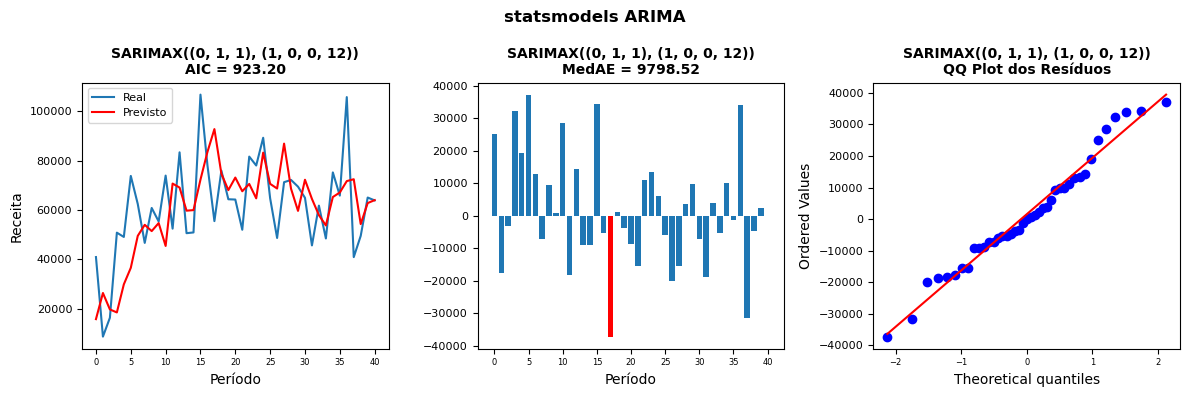

In [26]:
# get error metrics

metrics = {}

metrics_df = pd.DataFrame.from_dict(error_metrics(df.iloc[1::,0].values, models_fittedvalues[best_aic_model]['fittedvalues'][1::].values), orient='index').transpose()
metrics_df['order'] = str(best_aic_model[0])
metrics_df['seasonal order'] = str(best_aic_model[1])
metrics_df['AIC'] = models_stats[best_aic_model]['AIC'].round(2)
metrics_df = metrics_df.set_index(['order','seasonal order'])

select_metrics = ['AIC', 'RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
model_error = metrics_df[select_metrics]

display(model_error)
print('\n\n')

#
# plot results
#

y_true = df.iloc[1::,0].values
y_pred = models_fittedvalues[best_aic_model]['fittedvalues'][1::].values
AICRMSE_str = 'AIC'
AICRMSE_value = models_stats[best_aic_model]['AIC'].round(2)
best_aic_model = best_aic_model
modelo = 'SARIMAX' + str(best_aic_model)
errors = y_true - y_pred
suptitle = 'statsmodels ARIMA'

plot_results1()

In [27]:
temp = pd.DataFrame.from_dict(models_stats, orient='index')[['AIC']]
temp = temp.loc[(best_aic_model[0], best_aic_model[1]),:].reset_index()
temp.columns = ['order', 'seasonal-order', 'AIC']
latex_table = gera_df_stats_latex(temp,'statsmodels - melhor modelo')
display(Latex(latex_table))

<IPython.core.display.Latex object>

In [28]:
best_aic_model

((0, 1, 1), (1, 0, 0, 12))

# Sarima: Predições 1M

In [29]:
order = best_aic_model[0]
seasonal_order = best_aic_model[1]

resultados = {}

for i in range(30, 42):
    train = df.iloc[i-30:i]

    try:
        sarima_model = ARIMA(train, order=order, seasonal_order=seasonal_order)
        sarima_fitted = sarima_model.fit()

        resultados[sarima_fitted.forecast(steps=1).index.values[0]] = sarima_fitted.forecast(steps=1).iloc[0]

    except Exception as e:
        print(f"Erro ao ajustar ou prever para o índice {i}: {e}")
        resultados[i] = {'aic': None, 'pred': None}

pred = pd.DataFrame.from_dict(resultados, orient='index')
pred.columns = ['pred']
pred
# pred_values = [resultados[i]['pred'] for i in resultados]
# pred_values

,pred
2023-07-01,61287.367135
2023-08-01,72237.442409
2023-09-01,64530.053002
2023-10-01,55868.822946
2023-11-01,55058.174396
2023-12-01,57052.611764
2024-01-01,64429.653414
2024-02-01,71091.277907
2024-03-01,75653.111488
2024-04-01,56968.280693


,,AIC,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE
order,seasonal order,,,,,,,,
"(0, 1, 1)","(1, 0, 0, 12)",923.2,16699.76,11591.55,0.21,0.23,0.85,0.01,7377.71


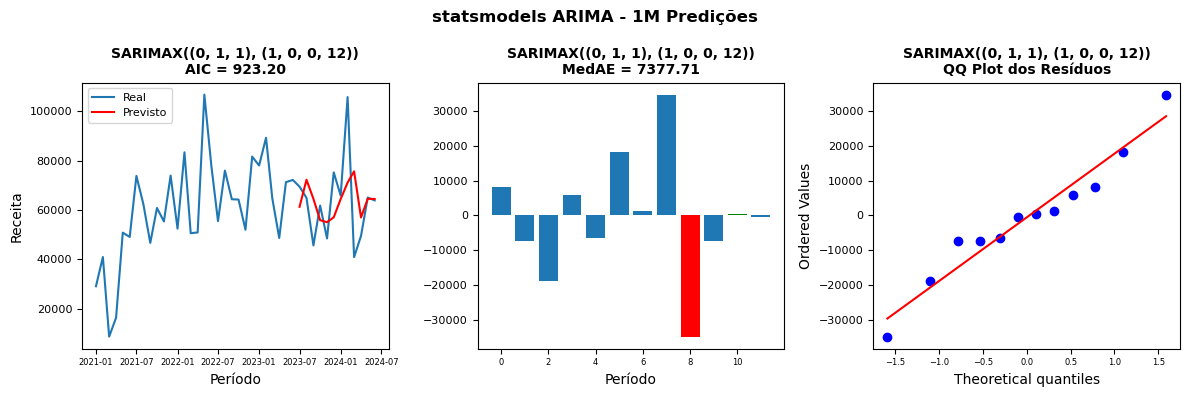

In [30]:
#
# get error metrics
#
metrics = {}

metrics_df = pd.DataFrame.from_dict(error_metrics(df.iloc[-12::,0].values, pred.pred.values), orient='index').transpose()
metrics_df['order'] = str(best_aic_model[0])
metrics_df['seasonal order'] = str(best_aic_model[1])
metrics_df['AIC'] = models_stats[best_aic_model]['AIC'].round(2)
metrics_df = metrics_df.set_index(['order','seasonal order'])

select_metrics = ['AIC', 'RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
model_error = metrics_df[select_metrics]

display(model_error)
print('\n\n')

#
# plot results
#

y_true = df.iloc[:,0]   # série completa
y_pred = pred             # predição, final da série
AICRMSE_str = 'AIC'
AICRMSE_value = models_stats[best_aic_model]['AIC'].round(2)
best_aic_model = best_aic_model
modelo = 'SARIMAX' + str(best_aic_model)
errors = df.iloc[-12::,0].values.flatten() - pred.values.flatten() # erro somente da previsão
suptitle = 'statsmodels ARIMA - 1M Predições'

plot_results1()

model_error_arima_1M = model_error.copy()

In [31]:
temp = model_error.reset_index()
temp.columns = [x.replace('_','-') for x in temp.columns]

latex_table = gera_df_stats_latex(temp,'SARIMAX' + str(best_aic_model))
display(Latex(latex_table))

<IPython.core.display.Latex object>

### Meses com maior e menor erro de predição

---

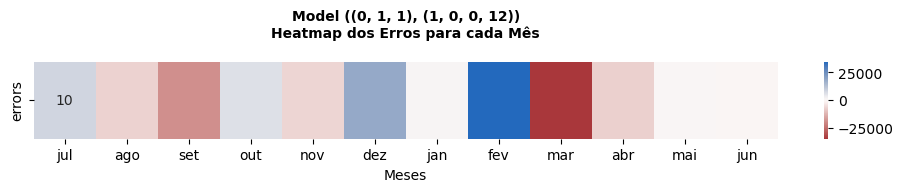

In [32]:
labels = ['jul','ago','set','out','nov','dez','jan','fev','mar','abr','mai','jun']

df_heatmap = pd.DataFrame({'labels': labels, 'errors': errors})

df_heatmap = df_heatmap.pivot_table(index='labels', values='errors').transpose()
df_heatmap = df_heatmap[['jul','ago','set','out','nov','dez','jan','fev','mar','abr','mai','jun']] # reorder

plt.figure(figsize=(12,1))
sns.heatmap(df_heatmap, annot=df_heatmap.rank(axis="columns"), fmt=".0f", cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.title(f'Model {best_aic_model}\nHeatmap dos Erros para cada Mês\n',weight='bold',fontsize=10)
plt.xlabel('Meses')

plt.show()

# SARIMA: Predições 3M

In [33]:
order = best_aic_model[0]
seasonal_order = best_aic_model[1]

resultados = {}

for i in range(30, 40):
    train = df.iloc[i-30:i]

    try:
        sarima_model = ARIMA(train, order=order, seasonal_order=seasonal_order)
        sarima_fitted = sarima_model.fit()

        resultados[sarima_fitted.forecast(steps=1).index.values[0]] = sarima_fitted.forecast(steps=3).iloc[0:3].values

    except Exception as e:
        print(f"Erro ao ajustar ou prever para o índice {i}: {e}")
        resultados[i] = {'aic': None, 'pred': None}

pred = pd.DataFrame.from_dict(resultados, orient='index')
# pred.columns = ['pred']
pred
# pred_values = [resultados[i]['pred'] for i in resultados]
# pred_values

,0,1,2
2023-07-01,61287.367135,68272.301490,64309.699230
2023-08-01,72237.442409,67637.765089,67592.578268
2023-09-01,64530.053002,64491.974633,60406.006882
2023-10-01,55868.822946,50603.004941,63354.945007
2023-11-01,55058.174396,65184.789608,63953.020530
2023-12-01,57052.611764,57533.647107,56033.013542
2024-01-01,64429.653414,65971.264303,62607.636130
2024-02-01,71091.277907,60932.585374,54278.791564
2024-03-01,75653.111488,70157.363042,77887.579698
2024-04-01,56968.280693,65783.270031,66135.940638


In [34]:
valores_window = []
for i in range(30, 40):
    valores_window.append(df.iloc[i:i+3].values)

valores_window

[array([[69440.2 ],
        [64929.9 ],
        [45665.75]]),
 array([[64929.9 ],
        [45665.75],
        [61775.05]]),
 array([[45665.75],
        [61775.05],
        [48473.79]]),
 array([[61775.05],
        [48473.79],
        [75213.5 ]]),
 array([[48473.79],
        [75213.5 ],
        [65811.65]]),
 array([[ 75213.5 ],
        [ 65811.65],
        [105702.45]]),
 array([[ 65811.65],
        [105702.45],
        [ 40913.  ]]),
 array([[105702.45],
        [ 40913.  ],
        [ 49520.4 ]]),
 array([[40913.  ],
        [49520.4 ],
        [65039.75]]),
 array([[49520.4 ],
        [65039.75],
        [63885.3 ]])]

In [35]:
metrics_df = pd.DataFrame.from_dict(error_metrics(np.array(valores_window).flatten(), np.array(pred.values).flatten()), orient='index').transpose()
metrics_df['order'] = str(best_aic_model[0])
metrics_df['seasonal order'] = str(best_aic_model[1])
metrics_df['AIC'] = models_stats[best_aic_model]['AIC'].round(2)
metrics_df = metrics_df.set_index(['order','seasonal order'])

select_metrics = ['AIC', 'RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
model_error = metrics_df[select_metrics]

display(model_error)
print('\n\n\n')

model_error_arima_3M = model_error.copy()

,,AIC,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE
order,seasonal order,,,,,,,,
"(0, 1, 1)","(1, 0, 0, 12)",923.2,18461.77,12260.35,0.23,0.2,0.85,0.01,9153.36


In [36]:
temp = model_error.reset_index()
temp.columns = [x.replace('_','-') for x in temp.columns]

latex_table = gera_df_stats_latex(temp,'SARIMAX' + str(best_aic_model))
display(Latex(latex_table))

<IPython.core.display.Latex object>

# XGboost

In [37]:
df.index = pd.date_range(start='1/1/2021', periods=len(df), freq='MS')
df.head()

,values
2021-01-01,29129.20
2021-02-01,40942.74
2021-03-01,8730.75
2021-04-01,16366.69
2021-05-01,50821.08


In [38]:
def create_lagged_features(data, n_lags):
    df = pd.DataFrame(data)
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df.iloc[:,0].shift(lag)
    return df.dropna()

In [39]:
df_saved = df.copy()

df = create_lagged_features(df, 30).copy()
df.head()

,values,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
2023-07-01,69440.20,72162.90,71259.29,48673.59,64730.75,89246.05,78010.25,81611.94,52001.74,64229.05,...,60817.49,46667.75,62422.10,73795.12,49084.82,50821.08,16366.69,8730.75,40942.74,29129.20
2023-08-01,64929.90,69440.20,72162.90,71259.29,48673.59,64730.75,89246.05,78010.25,81611.94,52001.74,...,55358.12,60817.49,46667.75,62422.10,73795.12,49084.82,50821.08,16366.69,8730.75,40942.74
2023-09-01,45665.75,64929.90,69440.20,72162.90,71259.29,48673.59,64730.75,89246.05,78010.25,81611.94,...,73920.39,55358.12,60817.49,46667.75,62422.10,73795.12,49084.82,50821.08,16366.69,8730.75
2023-10-01,61775.05,45665.75,64929.90,69440.20,72162.90,71259.29,48673.59,64730.75,89246.05,78010.25,...,52443.10,73920.39,55358.12,60817.49,46667.75,62422.10,73795.12,49084.82,50821.08,16366.69
2023-11-01,48473.79,61775.05,45665.75,64929.90,69440.20,72162.90,71259.29,48673.59,64730.75,89246.05,...,83342.34,52443.10,73920.39,55358.12,60817.49,46667.75,62422.10,73795.12,49084.82,50821.08


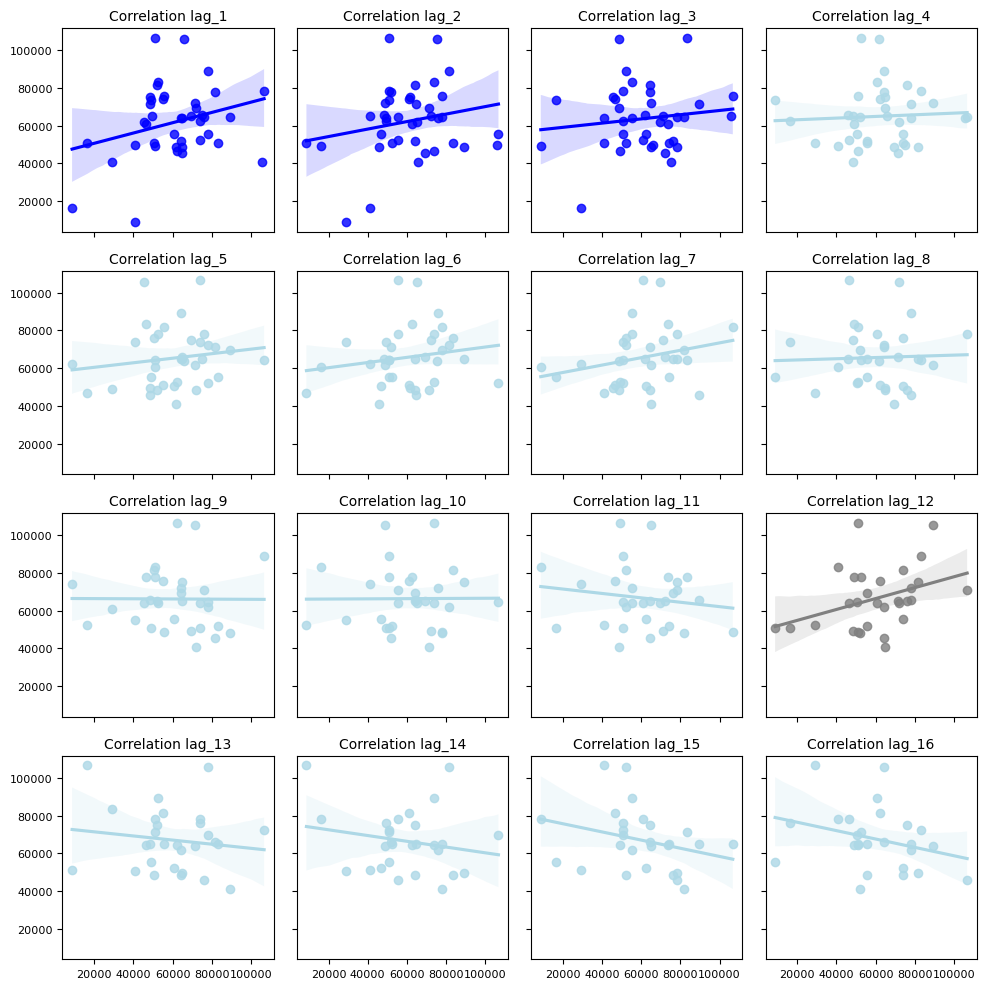

In [40]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), sharey=True, sharex=True)
ax = ax.flatten()

for i in range(16):
  df_ac = df_saved.copy()
  df_ac['lag_'+str(i+1)] = df_ac['values'].shift(i+1)
  df_ac.dropna(inplace=True)

  if i in [0, 1, 2]: # lags - 1
    color='blue'
  elif i == 11:
    color='gray'
  else:
    color='lightblue'

  sns.regplot(x='lag_'+str(i+1),y='values',data=df_ac, order=1,ax=ax[i], color=color)
  ax[i].set_title(f'Correlation ' + 'lag_'+str(i+1),fontsize=10)
  ax[i].set_ylabel('')
  ax[i].set_xlabel('')
  ax[i].tick_params(axis='x',labelsize=8)
  ax[i].tick_params(axis='y',labelsize=8)

plt.tight_layout()
plt.show()

In [41]:
seed_value = 42
np.random.seed(seed_value)
xgb.set_config(verbosity=0)

In [42]:
models_stats = {}
models_fittedvalues = {}

for n_lags in range(1,30):
  print(f'Starting train for {n_lags} lags')
  for i in range(30, 42):
    X_train = df.iloc[:,1:n_lags+1]
    y_train = df.iloc[:,0]

    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, seed=42)
    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict(X_train)

    models_stats[('XGBOOST', n_lags)] = error_metrics(df.iloc[:,0].values, y_pred)
    models_fittedvalues[('XGBOOST', n_lags)] = {'fittedvalues':y_pred}

Starting train for 1 lags
Starting train for 2 lags
Starting train for 3 lags
Starting train for 4 lags
Starting train for 5 lags
Starting train for 6 lags
Starting train for 7 lags
Starting train for 8 lags
Starting train for 9 lags
Starting train for 10 lags
Starting train for 11 lags
Starting train for 12 lags
Starting train for 13 lags
Starting train for 14 lags
Starting train for 15 lags
Starting train for 16 lags
Starting train for 17 lags
Starting train for 18 lags
Starting train for 19 lags
Starting train for 20 lags
Starting train for 21 lags
Starting train for 22 lags
Starting train for 23 lags
Starting train for 24 lags
Starting train for 25 lags
Starting train for 26 lags
Starting train for 27 lags
Starting train for 28 lags
Starting train for 29 lags


In [43]:
pd.DataFrame.from_dict(models_stats, orient='index').sort_values('RMSE',ascending=True)

R2  RMSE   MAE  MedAE  MAPE  RMSE_std  RMSE_min  RMSE_max  \
XGBOOST 3   1.0  4.21  2.15   0.54   0.0      3.63      0.03     12.92   
        4   1.0  4.21  2.12   0.46   0.0      3.64      0.01     12.92   
        15  1.0  4.22  1.95   0.21   0.0      3.75      0.02     12.93   
        16  1.0  4.22  1.95   0.21   0.0      3.75      0.02     12.93   
        14  1.0  4.22  1.95   0.21   0.0      3.75      0.02     12.93   
        13  1.0  4.22  1.95   0.21   0.0      3.75      0.02     12.93   
        12  1.0  4.22  1.95   0.21   0.0      3.75      0.02     12.93   
        20  1.0  4.22  1.95   0.20   0.0      3.75      0.04     12.93   
        21  1.0  4.22  1.95   0.20   0.0      3.75      0.04     12.93   
        22  1.0  4.22  1.95   0.20   0.0      3.75      0.04     12.93   
        23  1.0  4.22  1.95   0.20   0.0      3.75      0.04     12.93   
        17  1.0  4.22  1.95   0.21   0.0      3.75      0.02     12.93   
        18  1.0  4.22  1.95   0.21   0.0      3.75      0.02     12.93   
        24  1.0  4.23  1.96   0.22   0.0      3.74      0.01     12.93   
        25  1.0  4.23  1.96   0.22   0.0      3.74      0.01     12.93   
        26  1.0  4.23  1.96   0.22   0.0      3.74      0.01     12.93   
        19  1.0  4.23  1.95   0.21   0.0      3.75      0.01     12.93   
        27  1.0  4.23  1.99   0.33   0.0      3.73      0.01     12.93   
        29  1.0  4.23  1.99   0.33   0.0      3.73      0.01     12.93   
        11  1.0  4.23  1.95   0.21   0.0      3.75      0.03     12.93   
        10  1.0  4.23  1.97   0.21   0.0      3.74      0.00     12.93   
        9   1.0  4.23  1.97   0.21   0.0      3.74      0.00     12.93   
        28  1.0  4.23  1.99   0.33   0.0      3.73      0.01     12.93   
        6   1.0  4.27  2.26   0.34   0.0      3.63      0.02     12.62   
        5   1.0  4.27  2.27   0.41   0.0      3.61      0.03     12.62   
        8   1.0  4.28  2.29   0.50   0.0      3.61      0.01     12.62   
        7   1.0  4.28  2.29   0.42   0.0      3.61      0.03     12.62   
        2   1.0  4.57  2.98   1.39   0.0      3.46      0.17     12.62   
        1   1.0  4.63  3.02   1.45   0.0      3.51      0.25     12.62   

            MAE_std  MAE_min  MAE_max  MedAE_std  MedAE_min  MedAE_max  \
XGBOOST 3      3.63     0.03    12.92       3.63       0.03      12.92   
        4      3.64     0.01    12.92       3.64       0.01      12.92   
        15     3.75     0.02    12.93       3.75       0.02      12.93   
        16     3.75     0.02    12.93       3.75       0.02      12.93   
        14     3.75     0.02    12.93       3.75       0.02      12.93   
        13     3.75     0.02    12.93       3.75       0.02      12.93   
        12     3.75     0.02    12.93       3.75       0.02      12.93   
        20     3.75     0.04    12.93       3.75       0.04      12.93   
        21     3.75     0.04    12.93       3.75       0.04      12.93   
        22     3.75     0.04    12.93       3.75       0.04      12.93   
        23     3.75     0.04    12.93       3.75       0.04      12.93   
        17     3.75     0.02    12.93       3.75       0.02      12.93   
        18     3.75     0.02    12.93       3.75       0.02      12.93   
        24     3.74     0.01    12.93       3.74       0.01      12.93   
        25     3.74     0.01    12.93       3.74       0.01      12.93   
        26     3.74     0.01    12.93       3.74       0.01      12.93   
        19     3.75     0.01    12.93       3.75       0.01      12.93   
        27     3.73     0.01    12.93       3.73       0.01      12.93   
        29     3.73     0.01    12.93       3.73       0.01      12.93   
        11     3.75     0.03    12.93       3.75       0.03      12.93   
        10     3.74     0.00    12.93       3.74       0.00      12.93   
        9      3.74     0.00    12.93       3.74       0.00      12.93   
        28     3.73     0.01    12.93       3.73       0.01      12.93   
        6      3

In [44]:
temp = pd.DataFrame.from_dict(models_stats, orient='index').sort_values('RMSE',ascending=True)
temp = temp[['RMSE','RMSE_std']].reset_index()
temp.columns = ['ML-Model', 'lag-parameter', 'RMSE','RMSE-std']

latex_table = gera_df_stats_latex(temp.head(),'XGBOOST')
display(Latex(latex_table))

<IPython.core.display.Latex object>

In [45]:
best_rmse_model = min(models_stats, key=lambda x: models_stats[x]['RMSE'])
print(f"The model with the lowest RMSE is: {best_rmse_model} with RMSE = {models_stats[best_rmse_model]['RMSE'].round(2)} and MAPE = {models_stats[best_rmse_model]['MAPE'].round(2)}")
print(models_stats[best_rmse_model])

The model with the lowest RMSE is: ('XGBOOST', 3) with RMSE = 4.21 and MAPE = 0.0
{'R2': 1.0, 'RMSE': 4.21, 'MAE': 2.15, 'MedAE': 0.54, 'MAPE': 0.0, 'RMSE_std': 3.63, 'RMSE_min': 0.03, 'RMSE_max': 12.92, 'MAE_std': 3.63, 'MAE_min': 0.03, 'MAE_max': 12.92, 'MedAE_std': 3.63, 'MedAE_min': 0.03, 'MedAE_max': 12.92, 'MAPE_std': 0.0, 'MAPE_min': 0.0, 'MAPE_max': 0.0}


In [46]:
metrics_df = pd.DataFrame.from_dict(models_stats[best_rmse_model], orient='index').transpose()
metrics_df['ML Model'] = str(best_rmse_model[0])
metrics_df['lag parameter'] = str(best_rmse_model[1])
metrics_df = metrics_df.set_index(['ML Model','lag parameter'])
metrics_df

select_metrics = ['RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
model_error = metrics_df[select_metrics]

display(model_error)
print('\n\n\n')

,,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE
ML Model,lag parameter,,,,,,,
XGBOOST,3,4.21,3.63,0.0,0.0,0.0,0.0,0.54


In [47]:
temp = model_error.reset_index()
temp.columns = [x.replace('_','-').replace(' ','-') for x in temp.columns]

latex_table = gera_df_stats_latex(temp.head(),'XGBOOST - melhor modelo')
display(Latex(latex_table))

<IPython.core.display.Latex object>

## Xgboost Seleção / Resultados

In [48]:
df = df_saved.copy() # restor unlagged

n_lags = best_rmse_model[1]
df = create_lagged_features(df, n_lags)
df.head()

,values,lag_1,lag_2,lag_3
2021-04-01,16366.69,8730.75,40942.74,29129.20
2021-05-01,50821.08,16366.69,8730.75,40942.74
2021-06-01,49084.82,50821.08,16366.69,8730.75
2021-07-01,73795.12,49084.82,50821.08,16366.69
2021-08-01,62422.10,73795.12,49084.82,50821.08


In [49]:
temp = df.reset_index()
temp.columns = ['t','valor_t','valor_{t-1}','valor_{t-2}','valor_{t-3}']

latex_table = gera_df_stats_latex(temp.head(),'Data - time lags')
display(Latex(latex_table))

<IPython.core.display.Latex object>

In [50]:
models_stats = {}
models_fittedvalues = {}

X_train = df.iloc[:,1:n_lags+1]
y_train = df.iloc[:,0]

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
model_xgb.fit(X_train, y_train)

for i in range(0, 43):
  X_test = df.iloc[:,1:n_lags+1]
  y_test = df.iloc[:,0]
  y_pred = model_xgb.predict(X_test)

  models_stats[('XGBOOST', n_lags)] = error_metrics(y_test.values, y_pred)
  models_fittedvalues[('XGBOOST', n_lags)] = {'fittedvalues':y_pred}

,,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE
ML Model,lag parameter,,,,,,,
XGBOOST,3,4.21,3.63,0.0,0.0,0.0,0.0,0.54


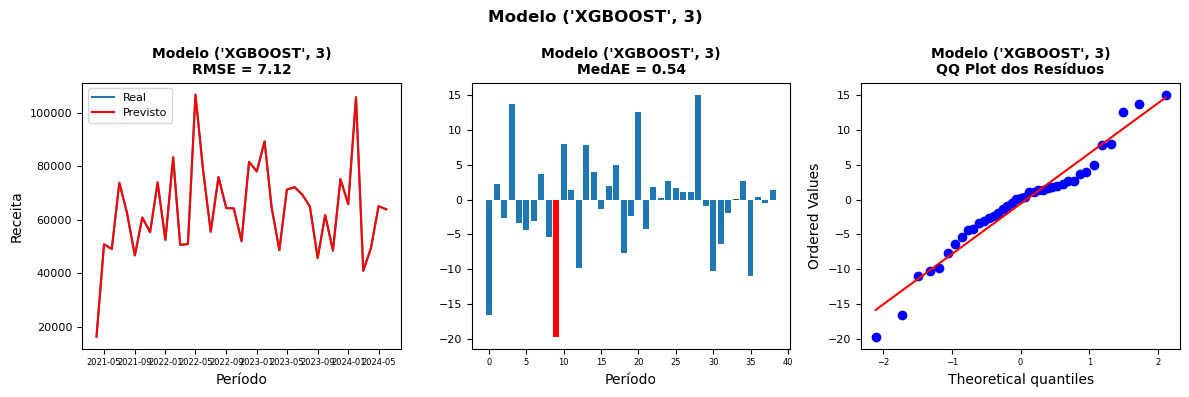

In [51]:
# get error metrics
metrics = {}

select_metrics = ['RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
model_error = metrics_df[select_metrics]

display(model_error)
print('\n\n')

#
# plot results
#

y_true = df.iloc[:,0]   # série completa
y_pred = pd.Series(data=models_fittedvalues[best_rmse_model]['fittedvalues'], index=df.index)  # passa série com datas
AICRMSE_str = 'RMSE'
AICRMSE_value = models_stats[best_rmse_model]['RMSE'].round(2)
modelo = f'Modelo {best_rmse_model}'
errors = y_true.values - y_pred.values
suptitle = f'Modelo {best_rmse_model}'


plot_results1()

In [52]:
temp = model_error.reset_index()
temp.columns = [x.replace('_','-').replace(' ','-') for x in temp.columns]

latex_table = gera_df_stats_latex(temp.head(),f'Modelo {best_rmse_model}')
display(Latex(latex_table))

<IPython.core.display.Latex object>

# XGBoost: Predições 1M

In [53]:
models_stats = {}
models_fittedvalues = {}

X_train = df.iloc[0:-12,1:n_lags+1]
y_train = df.iloc[0:-12,0]

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
model_xgb.fit(X_train, y_train)

X_test = df.iloc[-12::,1:n_lags+1]
y_test = df.iloc[-12::,0]
y_pred = model_xgb.predict(X_test)

models_stats[('XGBOOST', n_lags)] = error_metrics(y_test.values, y_pred)
models_fittedvalues[('XGBOOST', n_lags)] = {'fittedvalues':y_pred}

,,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE
ML Model,lag parameter,,,,,,,
XGBOOST,3,15559.81,9974.64,0.18,0.11,0.39,0.02,10222.65


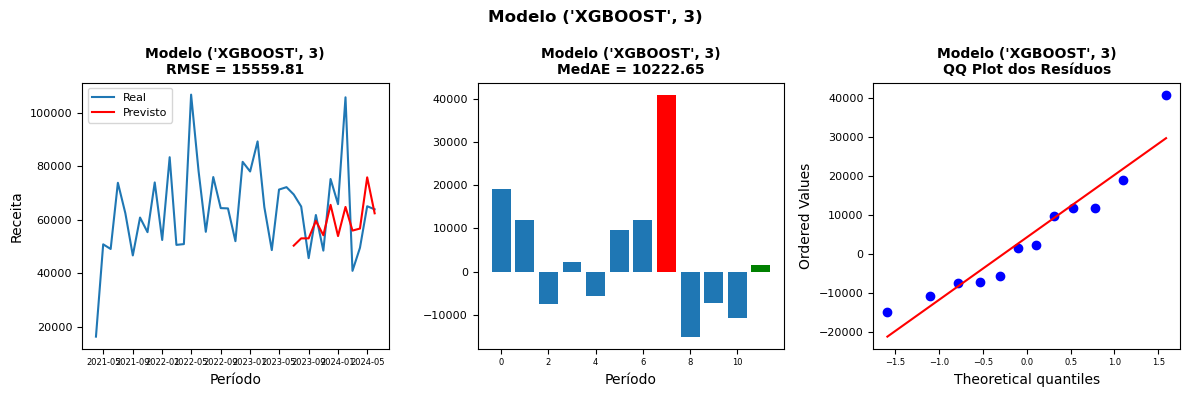

In [54]:
#
# get error metrics
#
metrics = {}

metrics_df = pd.DataFrame.from_dict(models_stats[best_rmse_model], orient='index').transpose()
metrics_df['ML Model'] = str(best_rmse_model[0])
metrics_df['lag parameter'] = str(best_rmse_model[1])
metrics_df = metrics_df.set_index(['ML Model','lag parameter'])
select_metrics = ['RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
model_error = metrics_df[select_metrics]

display(model_error)
print('\n\n')

#
# plot results
#

y_true = df.iloc[:,0]   # série completa
y_pred = pd.Series(data=models_fittedvalues[best_rmse_model]['fittedvalues'], index=df.iloc[-12::,0].index)  # passa série com datas
AICRMSE_str = 'RMSE'
AICRMSE_value = models_stats[best_rmse_model]['RMSE'].round(2)
modelo = f'Modelo {best_rmse_model}'
errors = df.iloc[-12::,0].values - y_pred.values
suptitle = f'Modelo {best_rmse_model}'


plot_results1()

model_error_xgboost_1M = model_error.copy()

In [55]:
temp = model_error.reset_index()
temp.columns = [x.replace('_','-').replace(' ','-') for x in temp.columns]

latex_table = gera_df_stats_latex(temp.head(),f'Modelo {best_rmse_model}')
display(Latex(latex_table))

<IPython.core.display.Latex object>

### Meses com maior e menor erro de predição

---

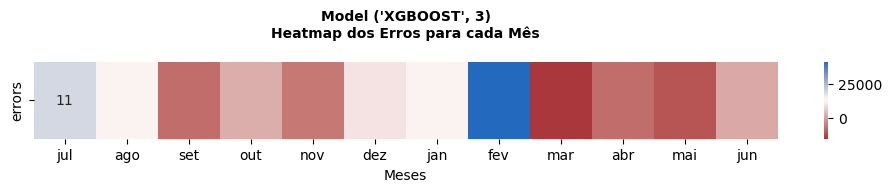

In [56]:
labels = ['jul','ago','set','out','nov','dez','jan','fev','mar','abr','mai','jun']

df_heatmap = pd.DataFrame({'labels': labels, 'errors': errors})

# Pivot the DataFrame to have labels as rows and columns
df_heatmap = df_heatmap.pivot_table(index='labels', values='errors').transpose()
df_heatmap = df_heatmap[['jul','ago','set','out','nov','dez','jan','fev','mar','abr','mai','jun']] # reorder

# Create the heatmap
plt.figure(figsize=(12,1))
sns.heatmap(df_heatmap, annot=df_heatmap.rank(axis="columns"), fmt=".0f", cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.title(f'Model {best_rmse_model}\nHeatmap dos Erros para cada Mês\n',weight='bold',fontsize=10)
plt.xlabel('Meses')

plt.show()

# XGBoost: Predições 3M

In [57]:
models_stats = {}
models_fittedvalues = {}

X_train = df.iloc[0:-12,1:n_lags+1]
y_train = df.iloc[0:-12,0]

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
model_xgb.fit(X_train, y_train)

forecast_steps = 3
y_pred = np.zeros([9,forecast_steps])

for i in range(9):
  rolling_predictions = forecast_rolling(model_xgb, df.iloc[i-12-n_lags:i-12,0].values, n_lags, forecast_steps)
  y_pred[i,:] = rolling_predictions

print(y_pred)

[[62696.9921875  52445.734375   60457.0625    ]
 [56046.24609375 53527.9921875  57457.9140625 ]
 [56046.24609375 50528.8359375  54852.9609375 ]
 [47334.234375   50308.9921875  57897.27734375]
 [51139.8984375  65335.484375   70937.3984375 ]
 [65452.8515625  59093.3125     58020.80078125]
 [53866.94921875 70515.9609375  56906.1328125 ]
 [68544.9296875  50719.6953125  48383.0390625 ]
 [66857.8046875  52813.49609375 63600.60546875]]


In [58]:
df = df_saved.copy()

valores_window = []
for i in range(30,39):
    valores_window.append(df.iloc[i:i+3,0].values)

valores_window

[array([69440.2 , 64929.9 , 45665.75]),
 array([64929.9 , 45665.75, 61775.05]),
 array([45665.75, 61775.05, 48473.79]),
 array([61775.05, 48473.79, 75213.5 ]),
 array([48473.79, 75213.5 , 65811.65]),
 array([ 75213.5 ,  65811.65, 105702.45]),
 array([ 65811.65, 105702.45,  40913.  ]),
 array([105702.45,  40913.  ,  49520.4 ]),
 array([40913.  , 49520.4 , 65039.75])]

In [59]:
metrics_df = pd.DataFrame.from_dict(error_metrics(np.array(valores_window).flatten(), np.array(y_pred).flatten()), orient='index').transpose()
metrics_df['ML Model'] = str(best_rmse_model[0])
metrics_df['lag parameter'] = str(best_rmse_model[1])
metrics_df = metrics_df.set_index(['ML Model','lag parameter'])

select_metrics = ['RMSE', 'RMSE_std', 'MAPE',  'MAPE_std', 'MAPE_max', 'MAPE_min', 'MedAE' ]
model_error = metrics_df[select_metrics]

display(model_error)
print('\n\n\n')

model_error_xgboost_3M = model_error.copy()

,,RMSE,RMSE_std,MAPE,MAPE_std,MAPE_max,MAPE_min,MedAE
ML Model,lag parameter,,,,,,,
XGBOOST,3,16900.37,11254.48,0.19,0.14,0.63,0.02,9806.7


In [60]:
temp = model_error.reset_index()
temp.columns = [x.replace('_','-').replace(' ','-') for x in temp.columns]

latex_table = gera_df_stats_latex(temp.head(),f'Modelo {best_rmse_model}')
display(Latex(latex_table))

<IPython.core.display.Latex object>

# Comparando resultado dos modelos

In [61]:
xgboost_1M = model_error_xgboost_1M.sort_values('MAPE').reset_index()
xgboost_1M.columns = [x.replace('_','-') for x in xgboost_1M.columns]
xgboost_1M['modelo'] = xgboost_1M['ML Model'] + '_' + xgboost_1M['lag parameter'].astype(str)
selected_columns = ['modelo', 'RMSE', 'RMSE-std', 'MAPE', 'MAPE-std', 'MedAE']
xgboost_1M = xgboost_1M[selected_columns]

arima_1M = model_error_arima_1M.sort_values('MAPE').reset_index()
arima_1M.columns = [x.replace('_','-') for x in arima_1M.columns]
arima_1M['modelo'] = 'SARIMA_' + arima_1M['order'] + '_' + arima_1M['seasonal order'].astype(str)
selected_columns = ['modelo', 'RMSE', 'RMSE-std', 'MAPE', 'MAPE-std', 'MedAE']
arima_1M = arima_1M[selected_columns]

results = pd.concat([xgboost_1M,arima_1M]).reset_index(drop=True)
results.sort_values(['RMSE'])

,modelo,RMSE,RMSE-std,MAPE,MAPE-std,MedAE
0,XGBOOST_3,15559.81,9974.64,0.18,0.11,10222.65
1,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",16699.76,11591.55,0.21,0.23,7377.71


In [62]:
latex_table = gera_df_stats_latex(results.sort_values(['RMSE']),'Melhores resultados, 1M')
display(Latex(latex_table))

<IPython.core.display.Latex object>

In [63]:
xgboost_3M = model_error_xgboost_3M.sort_values('MAPE').reset_index()
xgboost_3M.columns = [x.replace('_','-') for x in xgboost_3M.columns]
xgboost_3M['modelo'] = xgboost_3M['ML Model'] + '_' + xgboost_3M['lag parameter'].astype(str)
selected_columns = ['modelo', 'RMSE', 'RMSE-std', 'MAPE', 'MAPE-std', 'MedAE']
xgboost_3M = xgboost_3M[selected_columns]

arima_3M = model_error_arima_3M.sort_values('MAPE').reset_index()
arima_3M.columns = [x.replace('_','-') for x in arima_3M.columns]
arima_3M['modelo'] = 'SARIMA_' + arima_3M['order'] + '_' + arima_3M['seasonal order'].astype(str)
selected_columns = ['modelo', 'RMSE', 'RMSE-std', 'MAPE', 'MAPE-std', 'MedAE']
arima_3M = arima_3M[selected_columns]

results = pd.concat([xgboost_3M,arima_3M]).reset_index(drop=True)
results.sort_values(['RMSE'])

,modelo,RMSE,RMSE-std,MAPE,MAPE-std,MedAE
0,XGBOOST_3,16900.37,11254.48,0.19,0.14,9806.70
1,"SARIMA_(0, 1, 1)_(1, 0, 0, 12)",18461.77,12260.35,0.23,0.20,9153.36


In [64]:
latex_table = gera_df_stats_latex(results.sort_values(['RMSE']),'Melhores resultados, 3M')
display(Latex(latex_table))

<IPython.core.display.Latex object>